# 1.0 An end-to-end classification problem (Testing)



## 1.1 Dataset description

The notebooks focus on a borrower's **credit modeling problem**. The database was downloaded through a dataquest project and is available at link below. The data is from **Lending Club** and contains data from loans made in the period **2007 to 2011**. Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. The **target variable**, or what we are wanting to predict, is whether or not, given a person's history, they will repay the loan.

You can download the data from the [Kaggle](https://www.kaggle.com/datasets/samaxtech/lending-club-20072011-data).

Let's take the following steps:

1. ETL (done)
2. Data Checks (done)
3. Data Segregation (done)
4. Training (done)
5. Test

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1fKGuR5U5ECf7On6Zo1UWzAIWZrMmZnGc"></center>

## 1.2 Install, load libraries

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 153 kB 30.8 MB/s 
     |████████████████████████████████| 181 kB 59.8 MB/s 
     |████████████████████████████████| 63 kB 724 kB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=bdf4f0b0799e419512a9c155d7b9ad6d7eed73891f2a1c6f3708c29e8e8b85a4
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import logging
import pandas as pd
import wandb
import time
import pytz
import datetime
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
# Login to Weights & Biases
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 1.3 Test evaluation

### 1.3.1 Definition of the base classes

This is necessary in order to ```joblib.load()```see the previous definitions used in the Train Pipeline.

In [4]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # customize feature?
        # How can I identify what needs to be modified? EDA!!!!
        if self.new_features:

            #adjust emp_lenght feature
            mapping_dict = {
                "emp_length": {
                    "10+ years": 10,
                    "9 years": 9,
                    "8 years": 8,
                    "7 years": 7,
                    "6 years": 6,
                    "5 years": 5,
                    "4 years": 4,
                    "3 years": 3,
                    "2 years": 2,
                    "1 year": 1,
                    "< 1 year": 0,
                    "n/a": 0
                }
            }
            df = df.replace(mapping_dict)

        # update column names
        self.colnames = df.columns

        return df
        
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

### 1.3.2 Evaluation

In [5]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "neural_network/test.csv:latest"

# name of the model artifact
artifact_model_name = "neural_network/keras_model.h5:latest"

# name of the pipe artifact
artifact_pipe_name = "neural_network/pipe_export.pkl:latest"

# name of the target encoder artifact
artifact_encoder_name = "neural_network/target_encoder:latest"

In [6]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

In [7]:
# initiate the wandb project
run = wandb.init(project="neural_network",job_type="test")

wandb: Currently logged in as: morsinaldo. Use `wandb login --relogin` to force relogin


In [8]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("loan_status")

24-07-2022 16:44:39 Downloading and reading test artifact
24-07-2022 16:44:40 Extracting target from dataframe


In [9]:
# Takes a look at test set
x_test.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,2700.0,36 months,9.91,87.01,2 years,RENT,45000.0,Not Verified,credit_card,10.16,0.0,2.0,11.0,0.0,3574.0,61.6,12.0
1,14000.0,60 months,19.42,366.42,10+ years,RENT,46500.0,Not Verified,debt_consolidation,15.14,1.0,0.0,13.0,0.0,10699.0,66.9,36.0
2,3000.0,36 months,12.29,100.06,< 1 year,RENT,42000.0,Not Verified,major_purchase,1.71,0.0,0.0,4.0,0.0,1487.0,45.1,9.0
3,1600.0,36 months,13.23,54.09,4 years,RENT,86000.0,Not Verified,credit_card,13.40,0.0,1.0,6.0,0.0,20164.0,85.0,23.0
4,7500.0,36 months,12.29,163.43,6 years,MORTGAGE,500000.0,Not Verified,home_improvement,2.19,0.0,1.0,10.0,0.0,6459.0,23.8,13.0


In [10]:
# Take a look at the target variable
y_test.head()

0     Fully Paid
1     Fully Paid
2    Charged Off
3     Fully Paid
4     Fully Paid
Name: loan_status, dtype: object

In [11]:
# Extract the encoding of the target variable
logger.info("Extracting the encoding of the target variable")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)

24-07-2022 16:44:41 Extracting the encoding of the target variable


In [12]:
# transform y_train
y_test = le.transform(y_test)
logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

24-07-2022 16:44:43 Classes [0, 1]: ['Charged Off' 'Fully Paid']


In [13]:
# target variable after the encoding
y_test

array([1, 1, 0, ..., 1, 1, 1])

In [14]:
pipe_export_path = run.use_artifact(artifact_pipe_name).file()
pipe = joblib.load(pipe_export_path)

In [15]:
# Download inference artifact
#logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
model = load_model(model_export_path)

In [16]:
new_data_test = pipe.transform(x_test)
# cat_names is a numpy array
cat_names = pipe.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = pipe.get_params()["num_pipeline"][2].get_feature_names_out()
#cat_names.append('home_ownership_NONE')
df_new_test = pd.DataFrame(new_data_test, columns = cat_names + num_names)
df_new_test.head()

,term_60 months,emp_length_1,emp_length_2,emp_length_3,emp_length_4,emp_length_5,emp_length_6,emp_length_7,emp_length_8,emp_length_9,...,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.054960,0.043624,0.339232,0.000000,0.250,0.225,0.0,0.023902,0.616617,0.113636
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.272167,0.045302,0.505509,0.090909,0.000,0.275,0.0,0.071552,0.669670,0.386364
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.065105,0.040268,0.057095,0.000000,0.000,0.050,0.0,0.009945,0.451451,0.079545
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.029369,0.089485,0.447412,0.000000,0.125,0.100,0.0,0.134852,0.850851,0.238636
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.114367,0.552573,0.073122,0.000000,0.125,0.200,0.0,0.043196,0.238238,0.125000


In [17]:
# predict
#logger.info("Infering")
predict = model.predict(df_new_test)

In [18]:
for i in range(len(predict)):
  if predict[i] >= 0.5:
    predict[i] = 1
  else:
    predict[i] = 0

In [19]:
test_loss, test_acc = model.evaluate(df_new_test, y_test, verbose=0)

In [20]:
logger.info("Test Accuracy: {}".format(test_acc))
logger.info("Test Loss: {}".format(test_loss))

24-07-2022 16:44:52 Test Accuracy: 0.8568521738052368
24-07-2022 16:44:52 Test Loss: 0.3864697813987732


In [23]:
x_test

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,2700.0,36 months,9.91,87.01,2 years,RENT,45000.0,Not Verified,credit_card,10.16,0.0,2.0,11.0,0.0,3574.0,61.6,12.0
1,14000.0,60 months,19.42,366.42,10+ years,RENT,46500.0,Not Verified,debt_consolidation,15.14,1.0,0.0,13.0,0.0,10699.0,66.9,36.0
2,3000.0,36 months,12.29,100.06,< 1 year,RENT,42000.0,Not Verified,major_purchase,1.71,0.0,0.0,4.0,0.0,1487.0,45.1,9.0
3,1600.0,36 months,13.23,54.09,4 years,RENT,86000.0,Not Verified,credit_card,13.40,0.0,1.0,6.0,0.0,20164.0,85.0,23.0
4,7500.0,36 months,12.29,163.43,6 years,MORTGAGE,500000.0,Not Verified,home_improvement,2.19,0.0,1.0,10.0,0.0,6459.0,23.8,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11298,1500.0,36 months,12.68,50.32,10+ years,MORTGAGE,80000.0,Not Verified,home_improvement,8.56,5.0,1.0,9.0,0.0,770.0,35.0,35.0
11299,22000.0,36 months,11.03,720.57,5 years,MORTGAGE,90000.0,Not Verified,debt_consolidation,17.39,0.0,1.0,15.0,0.0,18913.0,34.1,26.0
11300,8000.0,36 months,12.61,268.06,1 year,RENT,80000.0,Not Verified,debt_consolidation,9.10,0.0,1.0,12.0,0.0,12551.0,68.2,20.0
11301,3500.0,36 months,11.71,115.77,1 year,RENT,31400.0,Not Verified,debt_consolidation,23.31,0.0,2.0,14.0,0.0,4941.0,48.9,29.0


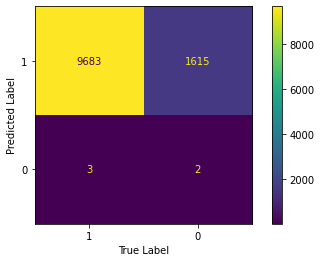

In [22]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=[1,0]),
                       display_labels=["1","0"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [26]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

24-07-2022 16:45:57 Uploading figures


In [ ]:
run.finish()